## 1 Accuracy(정확도)

### 1. 정확도(Accuracy) : 실제데이터와 예측데이터가 얼마나 같은지를 판단하는 지표
- 정확도 = 예측 데이터가 동일한 데이터 건수 / 전체 예측 데이터 건수
- 직관적으로 모델 예측 성능을 나타내는 평가 지표이지만 이진 분류의 경우 데이터의 구성에 따라 모델 성능을 왜곡할 수 있음

가령, 타이타닉 예제에서도 여성의 생존률이 높았기 때문에, 특별한 알고리즘 없이 여성을 생존, 남성을 사망으로 분류해도 정확도는 높을 수 있음 ( 단순히 하나의 조건만 가지고 결정하는 알고리즘도 높은 정확도를 나타내는 상황이 발생)

사이킷런의 BaseEstimator 클래스를 활용하여, 단순히 성별에 따라 생존자를 예측하는 단순한 분류기를 생성

- 사이킷런의 BaseEsimators를 활용하면 Customized된 Estimator를 생성할 수 있음

In [1]:
import numpy as np
### fit() 메서드는 아무 것도 수행하지 않고, predict()는 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측하는 단순한 분류기 생성
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict 메서드는 단순히 Sex 피처가 1이면 0, 아니면 1로 예측
    def predict(self, X):
        pred = np.zeros( (X.shape[0],1) )
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1 
        return pred

In [2]:
## 생성된 MyDummyClassifier를 이용해 타이타닉 생존자 예측 수행

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용하여 학습/예측/평가 수행. 
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test , mypredictions)))

Dummy Classifier의 정확도는: 0.7877


위와 같은 단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도는 78.77%로 매우 높은 수치로 나올 수 있기 때문에 정확도를 평가지표로 사용할 때는 매우 신중해야 함.

특히, Imbalanced한 레이블 값 분포에서 모델 성능을 판단할 경우에는 적합한 평가 지표가 아님

가령, 100개의 데이터 중 90개의 레이블이 0, 10개의 레이블이 1인 경우에 무조건 0을 반환하는 모델을 만들면 정확도가 90%가 됨

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros( (len(X),1) , dtype=bool)

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩
digits = load_digits()

# digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환. 
y = (digits.target == 7).astype(int)

# 훈련셋, 테스트셋으로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split( digits.data, y, random_state=11)

In [10]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fake_prediction = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fake_prediction)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


위와 같이 단순히 한 가지 값만으로 결과를 반환해도 정확도의 90%를 나타냄

이처럼 정확도 평가지표는 불균형한 레이블 데이터 셋에서는 성능지표로 사용되서는 안됨

→ 이를 극복하기 위해 정확도는 여러 지표와 함께 적용되어야 함

## 2. 오차행렬/혼동행렬 (Confusion Matrix)¶

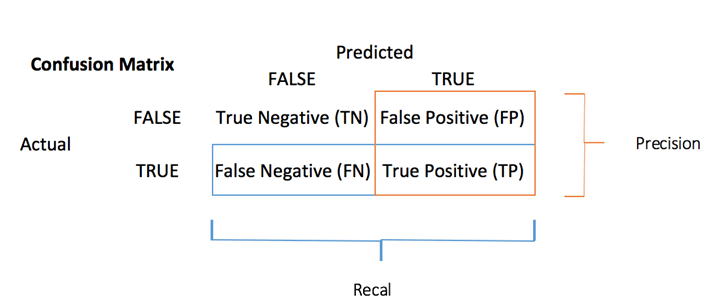

- TN(TrueNegative)
  : 실제 값이 Negative인데 예측 값도 Negative
- FP(FalsePositive)
  : 실제 값이 Negative인데 예측 값을 Positive
- FN(FalseNegative)
  : 실제 값이 Positive인데 예측 값을 Negative
- TP(TruePositive)
  : 실제 값이 Positive인데 예측 값도 Positive

사이킷런에서는 오차행렬을 구하기 위해 confusion_matrix( )를 제공

In [11]:
# MyFakeClassifier의 예측 결과인 fakepred와 실제결과인 y_test를 confusion_matrix의 인자로 입력해서 출력
from sklearn.metrics import confusion_matrix

# 앞절의 예측 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix출력
cm = confusion_matrix(y_test, fake_prediction)
cm

array([[405,   0],
       [ 45,   0]], dtype=int64)

오차행렬은 ndarray형태로 TP, FP, FN, TN은 위의 상단 표와 동일하게 배치

위의 결과를 보면 총 450개의 값 중

TN : 405개, TP : 0개, FN : 45개, FP : 0개

In [12]:
print('True Negative : ' , cm[0][0], ' --> (7이 아닌데 7이 아니라고 예측)')
print('False Positive : ', cm[0][1], '--> (7이 아닌데 7이라고 예측)')
print('False Negative : ', cm[1][0], '--> (7인데 7이 아니라고 예측)')
print('True Positigve: ', cm[1][1], '--> (7인데 7이라고 예측)')


True Negative :  405  --> (7이 아닌데 7이 아니라고 예측)
False Positive :  0 --> (7이 아닌데 7이라고 예측)
False Negative :  45 --> (7인데 7이 아니라고 예측)
True Positigve:  0 --> (7인데 7이라고 예측)


- Accuracy(정확도)=TN+TP/(TN+FP+FN+TP) 
 
  → 예측결과와 실제값이 동일한 건수 / 전체 데이터 수


- Precision(정밀도)=TP/(FP+TP) 
 

  → 예측대상(Positive)을 정확히 예측한 수 / Positive로 예측한 데이터 수


- Recall(재현율),Sensitivity(민감도),TruePositiveRate(TPR)=TP(FN+TP) 
 

  → Positive를 정확히 예측한 수 / 전체 Positive 데이터 수


- Specificity(특이성),TrueNegativeRate(TNR)=TN(TN+FP) 
 

  → Negative를 정확히 예측한 수 / 전체 Negative 데이터 수
업무 특성에 따라서 특정지표가 유용하게 사용

ex) Recall(재현율) : 암 판정, 사기 판정 / Precision(정밀도) : 스팸메일 분류

- 사이킷런에서는 정밀도 계산을 위해 precision_score( ) , 재현율 계산을 위해 recall_score( ) 를 제공

## 3 Precision과 Recall

In [28]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [29]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, \
                                                    test_size=0.20, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Precision/Recall Trade-off

- 정밀도/재현율 트레이드오프
- 정밀도와 재현율은 상호보완적인 지표로 한쪽을 높이려고 하다보면 다른 한쪽이 떨어지기 쉬움
- 사이킷런의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지 판단하기 위해 개별 레이블별로 확률을 구하고, 그 확률이 큰 레이블 값으로 예측
- 일반적으로는 임계값을 50%로 정하고 이보다 크면 Positive, 작으면 Negative로 결정
- predict_proba( ) 를 통하여 개별 레이블별 예측확률을 반환받을 수 있음

In [15]:
pred_proba = lr_clf.predict_proba(X_test)
pred  = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])


pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46201037 0.53798963]
 [0.87871916 0.12128084]
 [0.87718186 0.12281814]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46201037 0.53798963 1.        ]
 [0.87871916 0.12128084 0.        ]
 [0.87718186 0.12281814 0.        ]]


반환 결과인 ndarray는 0과 1에 대한 확률을 나타내므로 첫번째 컬럼과 두번째 컬럼의 합은 1이 됨

그리고 두 확률 중 큰 값의 레이블 값으로 predict( ) 메서드가 최종 예측

정밀도/재현율 트레이드오프를 살펴보기 위해 로직을 구현해보기
- 사이킷런의 Binarizer 클래스 : fit_transform()을 이용하여 정해진 threshold 보다 같거나 작으면 0, 크면 1로 변환하여 반환

In [31]:
from sklearn.preprocessing import Binarizer

X = [[ 1, -1,  2],
     [ 2,  0,  0],
     [ 0,  1.1, 1.2]]

# threshold 기준값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)                     
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


앞선 Logistic Regression 객체의 predict_proba()의 결과 값에 Binarizer클래스를 적용하여 최종 예측 값을 구하고, 최종 예측 값에 대해 평가해보기



In [32]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임.  
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼 , 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


In [18]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361


→ threshold를 낮추니 정밀도는 떨어지고, 재현율이 올라감 (즉, 0.4부터 Positive로 예측을 하니, 전체 Positive 수 대비 Positive로 예측된 값의 수가 많아짐)

임계값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가지표를 조사

In [19]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장. 
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


- precision_recall_curve(실제 클래스 값, 예측 확률 값) : 임계값 변화에 따른 평가 지표 값을 반환하는 API
- 반환 값 : 정밀도 - 임계값별 정밀도 값을 배열으로 반환, 재현율 - 임계값별 재현율 값을 배열으로 반환

In [20]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.01 0.09 0.11 0.13 0.15 0.23 0.35 0.5  0.63 0.75 0.89]
샘플 임계값별 정밀도:  [0.341 0.372 0.415 0.448 0.505 0.585 0.688 0.774 0.913 0.935 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.918 0.902 0.902 0.869 0.787 0.689 0.475 0.246]


정밀도와 재현율 값을 살펴보면 임계값이 증가할 수록 정밀도 값은 동시에 높아지나 재현율 값이 낮아짐을 알 수 있음

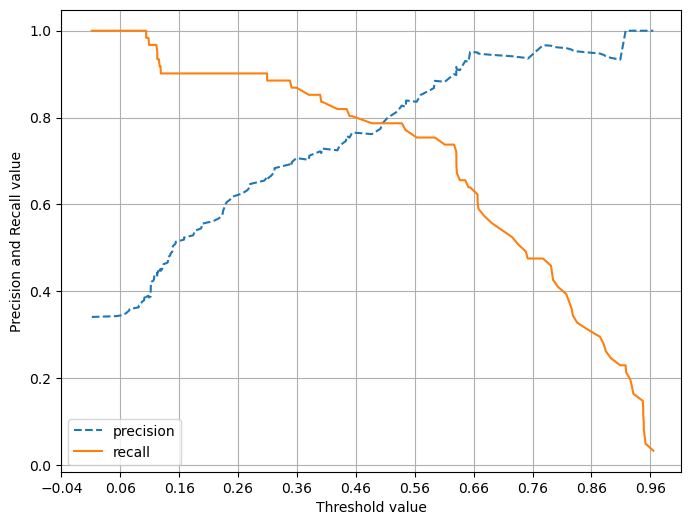

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )


### 4 F1 Score

정밀도와 재현율을 결합한 지표로 정밀도와 재현율이 어느 한 쪽으로 치우치지 않을 때 상대적으로 높은 값을 가짐

F1=2/(1/recall+1/precision) =2∗precision∗recall/(precision+recall) 
 
예시 ) 모델 A : 정밀도 0.9, 재현율이 0.1 , 모델 B : 정밀도 0.5, 재현율 0.5 일 때

→ 모델 A의 F1 = 0.18 , 모델 B의 F1 = 0.5

f1_score(실제값, 예측값) : 사이킷런에서 F1스코어를 측정

In [22]:
from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))


F1 스코어: 0.7805


타이타닉 생존자 예측에서 임계값을 변화시키며 F1 스코어, 정밀도, 재현율 구하기¶


In [23]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도: 0.7183, 재현율: 0.8361, F1:0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


## 5 ROC Curve와 AUC

- ROC곡선
  : FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선

- Recall(재현율),Sensitivity(민감도),TPR=TP/(FN+TP) 
 

→ 실제값 Positive가 정확이 예측되야 하는 수준(질병 보유자를 질병을 보유한 것으로 판정)
- Specificity(특이성),TrueNegativeRate(TNR)=TNTN+FP 
 

→ 실제값 Negative가 정확히 예측되야 하는 수준(건강한 사람을 건강하다고 판정)
- FPR=1−Specificity=FPTN+FP 
  --> 실제값 Negative 중 Positive로 잘못 예측된 비율(건강한 사람을 질병이 있다고 판정)

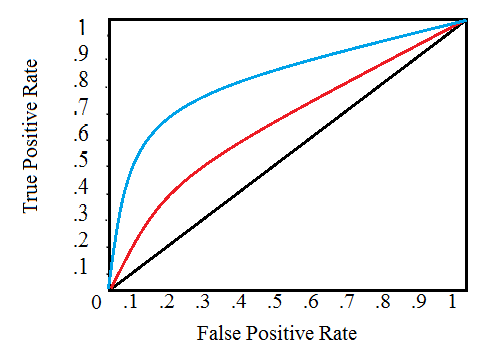

- 위의 그림은 ROC 곡선의 예시이며 가운데 직선은 ROC 곡선의 최저 값

- 가운데 직선은 동전을 무작위로 던져 앞/뒤를 맞추는 랜덤 수준의 이진 분류 ROC 직선
- 곡선이 가운데 직선에 가까울 수록 성능이 떨어지는 것이며 멀어질수록 성능이 뛰어난 것
- ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구함

- 분류결정 임계값을 변경함으로써 FPR을 변화시킴('임계값=1'이면 Negative 값을 Positive로 예측하지 않고 FPR이 0이됨, 반대로 임계값을 낮출수록 FPR이 올라감)

- 타이타닉 생존자 예측모델의 FPR, TPR, 임계값 구하기

In [24]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))


샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45 50]
샘플용 10개의 임곗값:  [ inf 0.75 0.63 0.59 0.49 0.4  0.35 0.23 0.13 0.12 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.051 0.127 0.161 0.203 0.331 0.585 0.636 0.797]
샘플 임곗값별 TPR:  [0.    0.475 0.689 0.754 0.787 0.836 0.869 0.902 0.918 0.967 0.967]


roc_curve( ) 의 결과값을 보면 임계값이 1에 가까운 값에서 점점 작아지면서 FPR이 점점 커짐

FPR이 조금씩 커질 때 FPR은 가파르게 커짐

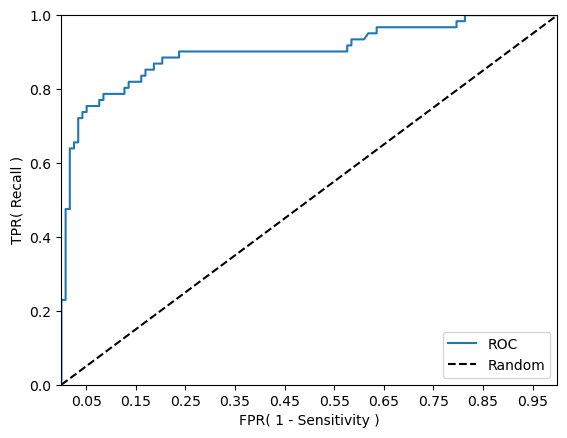

In [25]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )


일반적으로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는데 이용하여 분류의 성능지표로는 ROC면적에 기반한 AUC 값으로 결정

- AUC(Area Under Curve) : 곡선 밑의 면적 값으로 1에 가까울 수록 좋은 수치, 대각선 직선일 때 0.5
- roc_auc_score( ) : AUC 면적을 구하는 사이킷런 API

In [26]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))


ROC AUC 값: 0.8341


In [34]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
